# Playing with the IBM Quantum Challenge

For 4 days last June, IBM put out a set of 4 Quantum Computing problems as part of its (annual?) Quantum Challenge. These ranged from basic problems to one problem which was challenging, even to the experts --according to the IBM team.

I took Problem 4 as an opportunity to develop more intuition about quantum circuits. In that problem, a 16-by-16 unitary matrix, $U$, was provided, and participants were asked to find the quantum circuit which reproduces it with some fidelity. Furthermore, the contestants were asked to minimize the number of gates in the solution circuit, by minimizing a cost function

$cost = n_{u3} + 10 n_{cx}$

where $n_{u3}$ is the number of U3 gates (simple 1-qubit rotations) and $n_{cx}$ the number of CNOT gates. These were the only two gates allowed, reflecting the hardware restrictions.

In [1]:
from unitary2circuit import *

First order of business was to look at the matrix $U$, in search of patterns and symmetries. I vizualized the real and imaginary parts of the matrix representation of $U$, as seen below.

Looking at the numerical values of each element, it became clear that there are many symmetries:
- The matrix is symmetric about the diagonal
- The matrix is symmetric about the "other diagonal"
- There is a repetition of 2x2, 4x4 and 8x8 sub-matrices if we look along the two diagonal directions

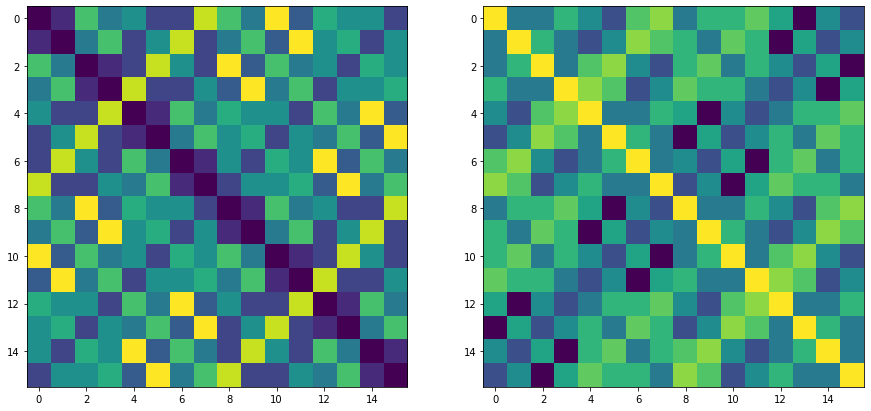

In [2]:
pl.figure(figsize=(15,10))
pl.subplot(121)
pl.imshow(uu.real)
pl.subplot(122)
pl.imshow(uu.imag)

The repitition is expected due to how tensor operations work. If operator $\mathbf{A}$ is acting on qubit 1, and $\mathbf{B}$ on qubit 2, then the overall matrix on this 2-qubit system is : 

$A \otimes B = 
\begin{pmatrix}
A_{11}\mathbf{B} & A_{12}\mathbf{B} \\
A_{21}\mathbf{B} & A_{22}\mathbf{B} 
\end{pmatrix} = 
\begin{pmatrix}
A_{11}\begin{pmatrix}B_{11} & B_{12} \\ B_{21} & B_{22}\end{pmatrix} & 
A_{12}\begin{pmatrix}B_{11} & B_{12} \\ B_{21} & B_{22}\end{pmatrix} \\
A_{21}\begin{pmatrix}B_{11} & B_{12} \\ B_{21} & B_{22}\end{pmatrix} & 
A_{22}\begin{pmatrix}B_{11} & B_{12} \\ B_{21} & B_{22}\end{pmatrix} 
\end{pmatrix}
$,

which is a 4-by-4 matrix. So one can see how $\mathbf{B}$ is repeated, and how the elements of $\mathbf{A}$ are factors of larger 2-by-2 blocks in the product matrix.

Now, in addition there are those two symmetries about each of the two diagonals of the matrix. This suggested that if we tensor multiply together matrices of the form $\begin{pmatrix}a & b \\ b & a\end{pmatrix}$, then we might obtain a matrix with the above symmetries. I checked and indeed it does. My initial hypothesis was to see if only four gates of this form --one on each qubit-- can reproduce this matrix. Such circuit will surely correspond to a matrix satisfying the above three bullet points. But will it be able to replicate the matrix $U$?



So what does a unitary matrix of the above form look like? In general, and up to an overall phase, any unitary matrix can be paramatrized as 

$
U_{gen} = 
\begin{pmatrix}
\cos{\frac{\theta}{2}}            & -e^{i \phi} \sin{\frac{\theta}{2}} \\ 
e^{i \lambda} \sin{\frac{\theta}{2}} & e^{i(\phi+\lambda)} \cos{\frac{\theta}{2}} \end{pmatrix}$

Imposing the above diagonal symmetries, this simplifies to a form depending on only one parameter, $\theta$:

$
U_{sym} = 
\begin{pmatrix}
\cos{\frac{\theta}{2}}   & i \sin{\frac{\theta}{2}} \\ 
i \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{pmatrix}$

This is simply an X rotation, sometimes denoted $R_X(\theta)$. Therefore, our four gates would only depend on four independent angles, one for each gate, and so optimizing over a four-dimensional parameter space wouldn't be that hard.

In fact, what's more intersting, if we divide the matrix $U$ in 2x2 adjacent matrices, then any of these are either proportional to $U_{22}$ or to $XU_{22}$, where $U_{22}$ is the matrix formed by the first 2 rows and first 2 columns of $U$, and $X$ is the Pauli X matrix.

In [3]:
print('U22 = ')
print(uu[0:2,0:2])
print()
print('The adjacent 2x2 matrix is proportional to U22')
print(uu[0:2,2:4] / uu[0:2,0:2])

U22 = 
[[-0.21338835+0.33838835j -0.14016504-0.08838835j]
 [-0.14016504-0.08838835j -0.21338835+0.33838835j]]

The adjacent 2x2 matrix is proportional to U22
[[-0.47140453-0.33333333j -0.47140453-0.33333335j]
 [-0.47140453-0.33333335j -0.47140453-0.33333333j]]


In [4]:
print('XU22 causes the elements to rotate around the matrix')
print(X @ uu[0:2,0:2]) 
print()
print('The 2x2 matrix starting at the 5th element is proportional to XU22:')
print(uu[4:6,0:2] / (X @ uu[0:2,0:2]))

XU22 causes the elements to rotate around the matrix
[[-0.14016504-0.08838835j -0.21338835+0.33838835j]
 [-0.21338835+0.33838835j -0.14016504-0.08838835j]]

The 2x2 matrix starting at the 5th element is proportional to XU22:
[[-0.33333335+0.47140453j -0.33333333+0.47140453j]
 [-0.33333333+0.47140453j -0.33333335+0.47140453j]]


If I make a mozaic of $U_{22}$ and $XU_{22}$ matrices and divide $U$ by that mosaic, I get the matrix below.

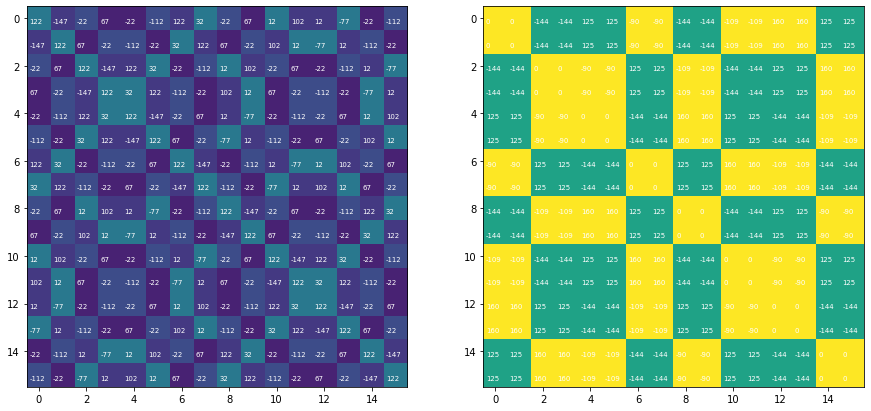

In [5]:
# plu() plots the input matrix's element norms, and adds the phase (in degrees) as text
pl.figure(figsize=(15,10))
pl.subplot(121)
plu(uu)
pl.subplot(122)
plu(uu / compru(uu[0:2, 0:2])) # compru makes the mosaic of U22 and XU22 matrices

This means that there are much fewer independent numbers that describe this matrix than the 256 elements in it! This further reinforces the idea that perhaps it is represented by a very small circuit. 

So I set out to solve this optimization problem of four gates with one independent angles each. I used the *differential_evolution()* function in the *optimize* package in SciPy. This function does a better job than others in sampling the parameters space, and is less likely to get stuck in the nearest local minimum of the cost function.

Below, I run the *opt4gates()* function I wrote to implement this optimization. After it finishes, it plots a histogram and image representation of $Re(U_{circ})/Re(U)$ where $U_{circ}$ is the calculated circuit's unitary. And it does the same for the imaginary parts of the two matrices.

/home/tyk/mysoft/anaconda3/envs/env_qiskit/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:461: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


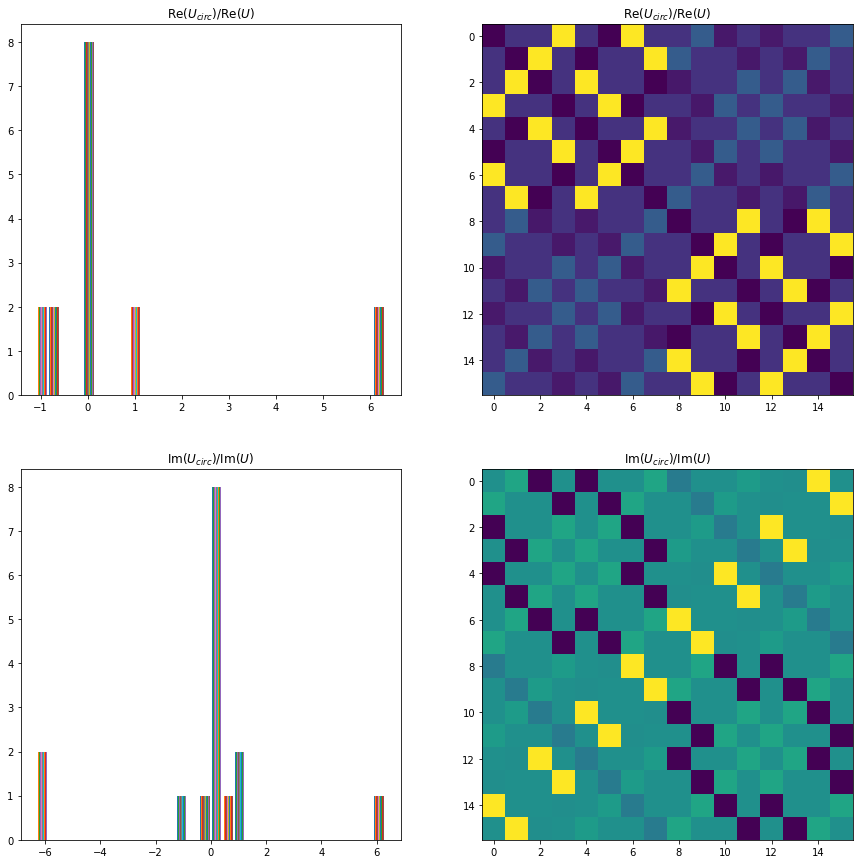

In [6]:
pl.figure(figsize=(15,15))
res, uc = opt4gates()

Another way to look at this, and to also take into account any overall phase shift between the two matrices is to plot the ratio of the two matrices, and plot the magnitudes (as colors) and the difference in their phase (as labels on each element.)

Text(0.5, 1.0, '$|U_{circ}|/|U|$ as colors, and phase difference as labels')

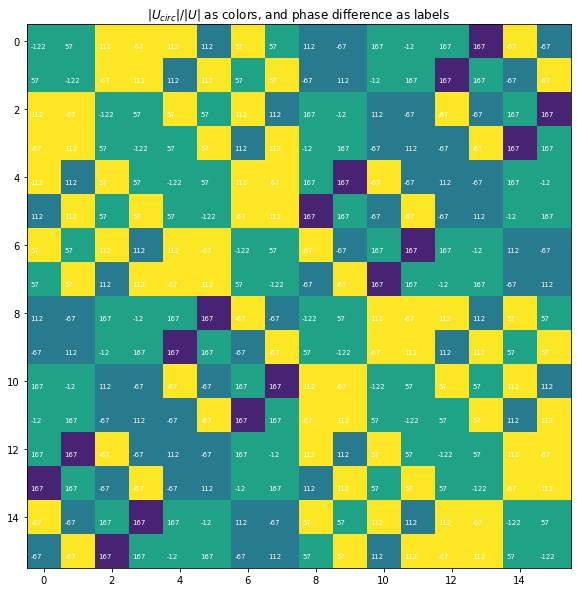

In [7]:
pl.figure(figsize=(10,10))

plu(uc/uu)
pl.title(r'$|U_{circ}|/|U|$ as colors, and phase difference as labels')

#pl.subplot(222)
#pl.imshow(uc.real/uu.real)
#pl.title(r'Re($U_{circ}$)/Re($U$)')

#pl.subplot(223)
#pl.imshow(np.abs(uc)/np.abs(uu), vmin=0)
#pl.title(r'|$U_{circ}$|/|$U$|')

#pl.subplot(224)
#pl.imshow((np.angle(uc)-np.angle(uu))/pi, vmin=-1, vmax=1)
#pl.title(r'(Phase($U_{circ}$)-Phase($U$))/2$\pi$')

In an interactive environment, it would be possible to hover over the figure and read the pixel values, corresponding to entries in the matrix. In this Jupyter notebook, I will instead print the ranges of the ratio images:

In [8]:
print('Maximum ratio of magnitudes = ', np.max(np.abs(uc)/np.abs(uu)) )
print('Minimum ratio of magnitudes = ', np.min(np.abs(uc)/np.abs(uu)) )
print('Maximum phase difference in degrees  = ', np.max( np.angle(uc) - np.angle(uu) ) * 180/pi )
print('Minimum phase difference in degrees  = ', np.min( np.angle(uc) - np.angle(uu) ) * 180/pi )


Maximum ratio of magnitudes =  3.36566314483488
Minimum ratio of magnitudes =  0.09895486554899799
Maximum phase difference in degrees  =  292.5000003157188
Minimum phase difference in degrees  =  -122.23561042248497


**The optimization's result is too different from $U$. It looks like the circuit is a bit more complex than four one-qubit rotations, after all.**

So it turns out that despite the similar symmetry in the matrices, my hypothesis circuit could not reproduce the give matrix $U$.

## Actually figuring it out

At some point during my investigation I became aware that one hint in the problem was "Hadamard." Applying a Hadamard operator to the matrix perhaps would simplify it? Indeed, that is the case. However, it's the application of 2 Hadamard gates (one before, and one after) that transforms U into a diagonal matrix, making it much simpler to handle:

In [9]:
# a Hadamard gate on 1 qubit
hh=np.array([[1,1],[1,-1]]) / 2**.5

# 4 Hadamard gates tensored together, equivalent to the matrix
# due one Hadamard on each of the 4 qubits
hh4=np.kron(hh, np.kron(hh, np.kron(hh,hh)))

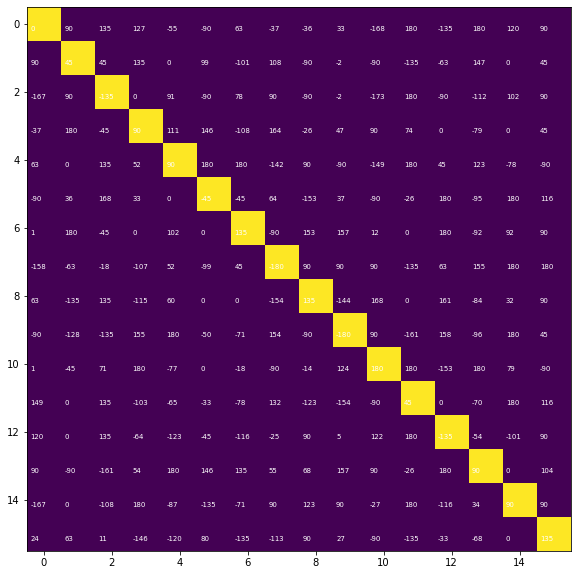

In [10]:
pl.figure(figsize=(10,10))
plu(hh4 @ uu @ hh4) # diagonal elements all have norm 1

Such a transformation of the form $A^\dagger U A$ is how one finds the equivalent matrix of an opperator in a *different* basis. In this case $H^\dagger$ happens to be equal to $H$. So the transformation becomes $HUH$.

So at this point, to solve the problem the clear path was to find the gates making up the diagonal matrices. This can be done either manually or using Qiskit functionality:

In [11]:
huh = hh4 @ uu @ hh4

qc = QuantumCircuit(4)
qc.h([0,1,2,3])
qc.diagonal( list( np.diagonal(huh)/np.abs( np.diagonal(huh) )) , [0,1,2,3] )
qc.h([0,1,2,3])

from qiskit.transpiler.passes import Unroller
from qiskit import transpile
from qiskit.transpiler import PassManager

qct = transpile( qc, basis_gates=['u3', 'cx'] )

pass_ = Unroller(['u3', 'cx'])
pm = PassManager( pass_ )
qct2 = pm.run(qct)

which does indeed resolve the diagonal matrix, albeit into a very large circuit:

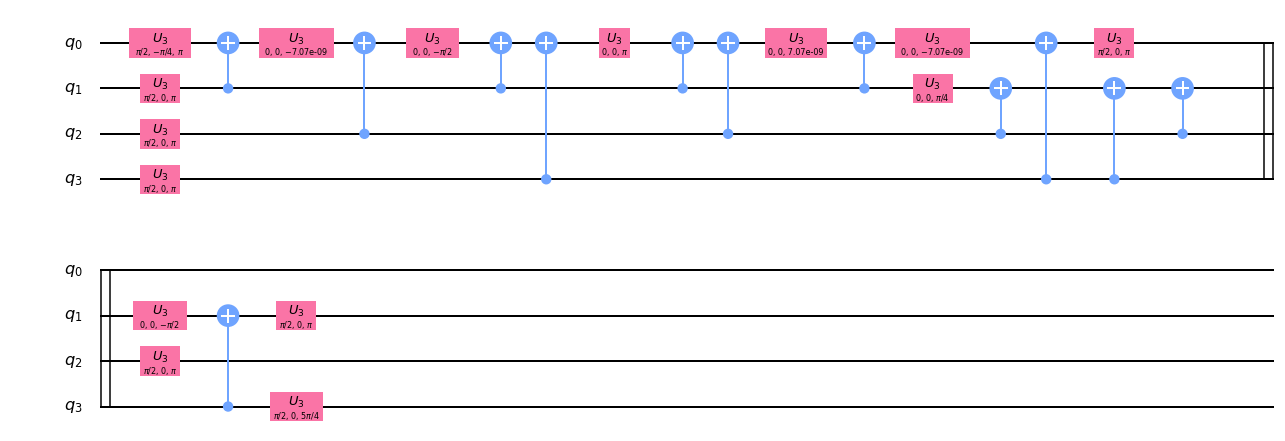

In [12]:
qct2.draw(output='mpl')

The manual solution, which is covered [here](https://www.youtube.com/watch?v=3oNXkCZ9odQ) can give a much shorter NISQ-friendly circuit.

## By products!

As a by-product of my working on this project here is a little interactive function that shows the matrix for a cicuit as you add gates to it. It plots the resulting $U_{circ}$ matrix on the right, and $U_{circ}/U$ on the right, since I used it to compare to the matrix of the problem.

Next gate: qc.h(0)


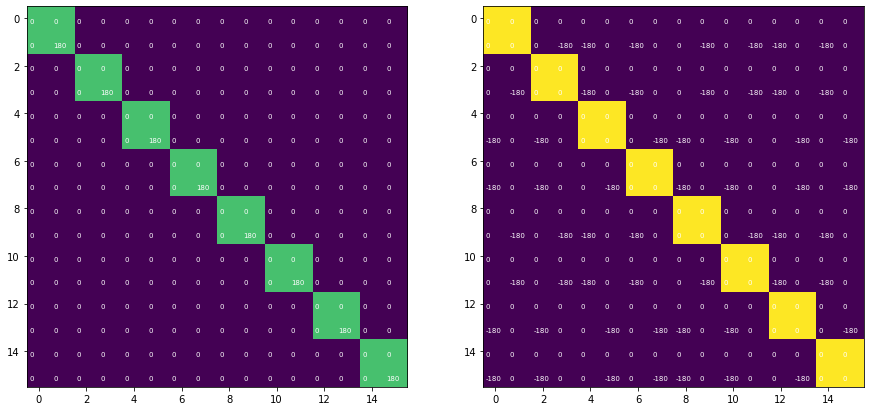

Next gate: qc.cx(0,2)


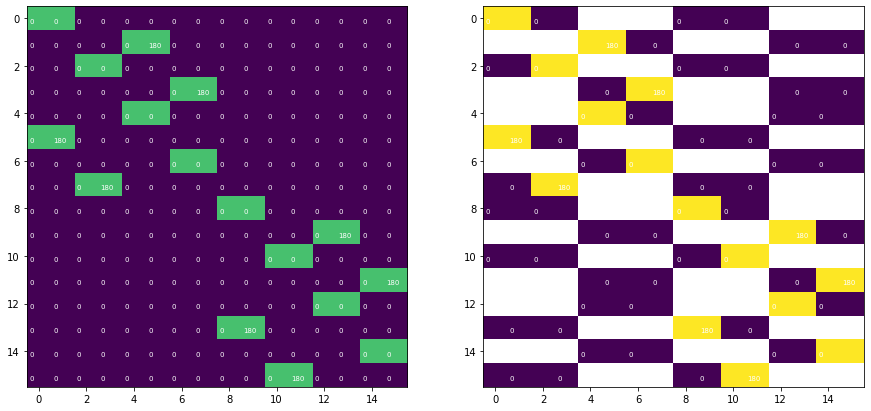

Next gate: qc.h(2)


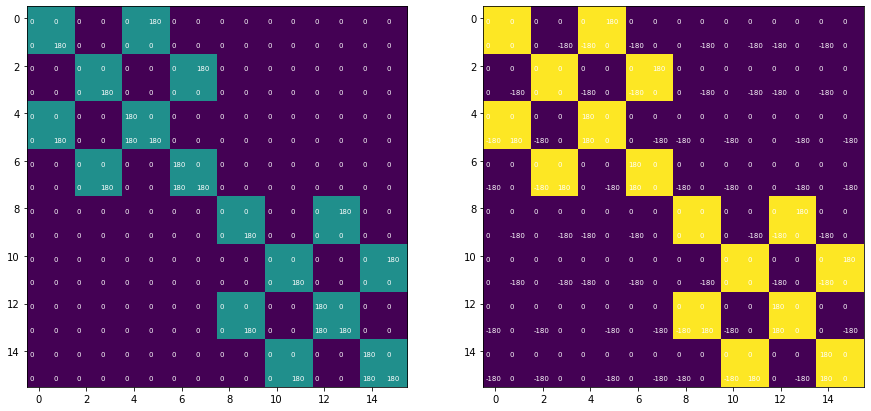

Next gate: q


In [15]:
pl.rcParams['figure.figsize'] = [15,10]
circ2matrix()